# A Healthy ParSplice Cluster
Danny said that a higher temperature would create more activity. He mentioned the `PARPSLICE_TASK_SEGMENT`, `Temperature`, and `InitTemperature` variables in the `ps-config.xml` configuration file for the LAMMPS engine that ParSplice uses. He suggested starting with a temperature of 2000 and an initial temperature of 400; then increasing from there. In this notebook, we try parameters sweeps on our old cluster (9 nodes each with 4 cores and 8GB of RAM) and on a [CloudLab](../docs/DEPLOY.md) cluster (7 nodes each with 36 cores and 64GB of RAM). First, we define some helper functions for plotting `times.out` and the performance counters collected by our customized LevelDB version.

In [1]:
from helpers import *
%matplotlib inline

## Experiment: Scale Temperatures Up

Setup: Old Cluster, 30 Minute Runtime

First we scale both temperatures up by a factor of 10, starting at a temperature of 10 and and initial temperature of 20. In the nomenclature below, `t` is temperature and `it` is initial temperature.

In [2]:
results = ["results-t1000it2000.xml-dbfix",
           "results-t2000it400.xml-dbfix",
           "results-t400it2000.xml-dbfix"]

### Overall Health (`times.out`)
These lines should be linear. One tool to make sure the system is healthy is the `times.out` file produced by ParSplice. The relationship between wall clock time and trajectory duration should be linear because it means the system is keeping up with the simulation load and is mirroring real time. According to Danny "In an ideal case, the trajectory length would proportional to the wall-clock time. Of course, seeing a linear trend alone does not tell you that you are running at the optimal simulation rate  (given by the slope), but usually a nice straight line means you are."

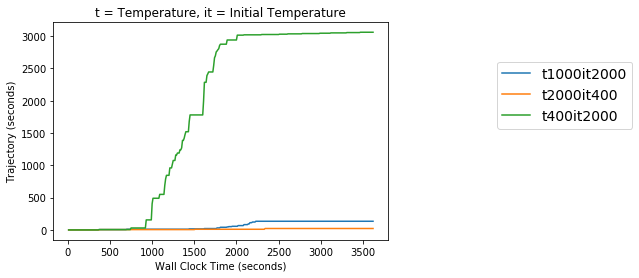

In [3]:
plot_times(results)

It *looks* like the higher the temperature, the more activity. But the database does not see much action.

### LevelDB Performance Counters
In the graphs below, we plot the activity on the persistent DB:

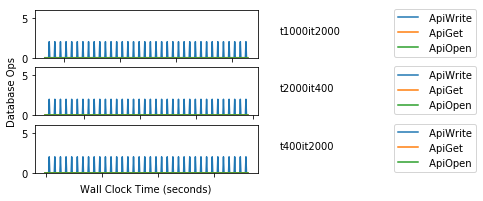

In [4]:
plot_dbactivity(results, dbnode='node-1')

This does not look right. We only see writes and they are not that frequent. There is definitely not a correlation between the temperature and the number of database operations.

#### ParSplice Performance Counters

Finally, we can take a look at the performance counters we added to ParSplice. We look at the in-memory database operations. Recall that this database is just an STL C++ unordered map that sits in front of the persistent database.

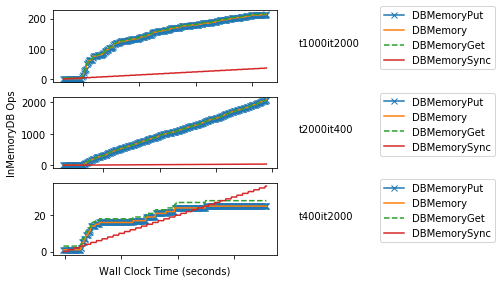

In [5]:
plot_psactivity(results, dbmemnode='node-2')

I showed this to Danny and he said this looks like a healthy setup. Some observations he made about my experiments:

- this U02 input does not stress the system enough, that's why the databases (both persistent and in-memory) can adequately service all reqeusts. We should see more transitions with the nanoparticle simulation he added yesterday.  We want to make sure that the temperatures are set at around 700K for these runs. If these still does not stress our system, we can try the KMC engine which simulates a bigger cluster by issuing and executing the database puts/gets with `no-op` calculations. 

- the `times.out` results look good. The `t400it2000` experiment flat-lining makes sense because the temperature should be `2x` greater than the initial temperature for the run to make sense.

- the 1-to-1 relationship of the in-memory database puts/gets looks normal. For this run, the cache on the work manager (implemented as an STL unordered map) services all producer requests. On a run with less locality, we should see this relationship lessen a bit as producers may need data from a cache on a different work manager.

- the persistent database does not see any `get()`s because all reads are satisfied from the in-memory database.